# Dependencies

In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

#from IPython.display import display, clear_output

#import pickle

#import random

#from itertools import combinations

# Functions

In [72]:
# function to run recursive feature elimination and output the reduced feature set
# function takes model input features (X_in), model output (y_in), number of features (N), 
# type of feature elimination (RFE or RFECV, sel) and verbosity (verb)
def feat_red(clf,X_in,y_in,N,sel,verb):
    estimator = clf
    if sel == 'RFECV':
        selector = RFECV(estimator, min_features_to_select=N, step=1,verbose=verb, cv = 3)
    else:
        selector = RFE(estimator,n_features_to_select=N,step=1,verbose=verb)
    selector = selector.fit(X_in,y_in)
    feat_out = selector.get_feature_names_out(X_in.columns)
    return feat_out

# runs feat_red function for all numbers of features in array N for input X (features) and y (model output)
# returns an array of feature sets for all specified N
def multi_feat_red(clf,X_in,Y_in,N,sel):
    feat_r = {}
    feat_r[0] = X_in.columns
    j=1
    for i in N:
        feat_r[j]= feat_red(clf,X_in[feat_r[j-1]],Y_in,i,sel,0)
        j=j+1
    return feat_r

# function to compare binary classification methods for input training X and Y arrays
def comp_bin(X_train,Y_train):
    
    print('   Balanced accuracy (SD)')
    # List of algorithms to test
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('DT', DecisionTreeClassifier(class_weight='balanced')))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto',class_weight='balanced')))
    models.append(('MLP', MLPClassifier(max_iter=1000)))
    models.append(('GB',GradientBoostingClassifier(random_state=0)))
    models.append(('RF',RandomForestClassifier(class_weight='balanced',random_state=0)))
    
    # Evaluate each model with 10-fold cross validation
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='balanced_accuracy')
        results.append(cv_results)
        names.append(name)
        print('%5s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        
    # Compare classification algorithms
    plt.boxplot(results, labels=names)
    plt.title('Classification Algorithm Comparison')
    plt.ylabel('Balanced accuracy')
    plt.ylim((0,1))
    plt.show()
    
    return results

# Testing a classifier with fit to X,Y with output of a confusion matrix and balanced accuracy score
def cm_test(clf,X,Y):
    clf.fit(X,Y)
    predictions = clf.predict(X)
    cm = confusion_matrix(Y, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()
    print("Balanced accuracy: ",balanced_accuracy_score(Y,clf.predict(X)))
    
# Comparison of feature sets (feat_r) using stratified 10-fold cross validation for a selected classifier (clf)
def feat_comp(clf,feat_r,X_train,Y_train,N_max):
    
    # output headers
    print('           Balanced accuracy')
    print(' i     N    Mean      (SD)')
    
    # defining array for results
    results = []
    
    for i in feat_r:
        
        # selecting columns from X_train corresponding to each feature set
        X_train2 = X_train[feat_r[i]]
        
        # finding balanced accuracy scores for stratified 10-fold cross validation 
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(clf, X_train2, Y_train, cv=kfold, scoring='balanced_accuracy')
        results.append(cv_results)
        
        # output results for each feature set
        print('%2i: %5i %f (%f)' % (i, feat_r[i].shape[0], cv_results.mean(), cv_results.std()))

    # calculating mean and standard deviation for scores
    scores = [score.mean() for score in results]
    stdevs = [score.std() for score in results]
    
    
    scores_rev = scores[::-1]
    
    
    plt.scatter([N_max]+N,scores)
    plt.ylabel('Balanced Accuracy')
    plt.xlabel('Number of features')
    
    return len(scores_rev) - np.argmax(scores_rev) - 2, scores, stdevs

def best_desc_comb(desc_rank,freq_thresh,n_desc,x_train,y_train,x_test,y_test):
    
    desc_rank_thresh = desc_rank[counts>freq_thresh]

    desc_comb =[]
    for comb in combinations(desc_rank_thresh,n_desc):
        desc_comb.append(comb)
    
    scores = []
    scores_test = []
    counter = 0
    for descs in desc_comb:
        X_train2 = x_train[list(descs)]
        X_test2 = x_test[list(descs)]
        clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')
        clf.fit(X_train2,y_train)
        predictions = clf.predict(X_train2)
        scores.append(balanced_accuracy_score(y_train,clf.predict(X_train2)))
        scores_test.append(balanced_accuracy_score(y_test,clf.predict(X_test2)))
        counter = counter + 1
        clear_output(wait=True)
        display(str(counter)+'/'+str(len(desc_comb)))
    print('Maximum score of:',max(scores),' for ',desc_comb[np.argmax(scores)],' with test score of: ',scores_test[np.argmax(scores)])
    best_comb = list(desc_comb[np.argmax(scores)])
    
    return best_comb, max(scores), scores_test[np.argmax(scores)], desc_comb, scores

# Data Import

In [87]:
# import data on RG fluorescence
corr_matrix = X_reduced.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [93]:
# import data on RG fluorescence
data = pd.read_csv('Data_files/RG_for_ML.csv')
 
# Remove features with variance below threshold or correlated to each other

# Threshold for variance
threshold = 0;
X = data.drop(['RG','Group','cb_pKa'],axis=1).select_dtypes(include='number');

scaler = preprocessing.MinMaxScaler()

X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

selector = VarianceThreshold(threshold)
selector.fit(X)
X_reduced = X_scaled[X_scaled.columns[selector.get_support(indices=True)]]

# Correlation matrix
corr_matrix = X_reduced.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_reduced = X_reduced.drop(to_drop, axis=1)

Y = data['RG_binary']

In [94]:
x=X_reduced
y=Y

# Compare binary classification methods

   Balanced accuracy (SD)
   LR: 0.681410 (0.147806)
  LDA: 0.552244 (0.147304)
  KNN: 0.709295 (0.154193)
   DT: 0.523718 (0.183042)
   NB: 0.517308 (0.116353)
  SVM: 0.695192 (0.194398)
  MLP: 0.555449 (0.112828)
   GB: 0.672756 (0.202185)
   RF: 0.542308 (0.104909)


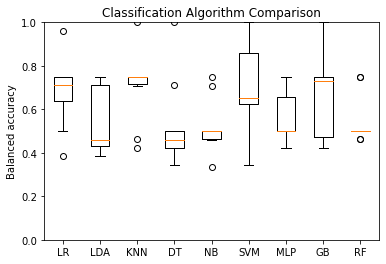

In [95]:
comp_bin_results = comp_bin(x,y)

In [96]:
comp_bin_df = pd.DataFrame(comp_bin_results)
comp_bin_df.to_csv('Data_files/For_plotting/model1_classification_method_comparison.csv')

# Run chosen classification method using all molecular descriptors

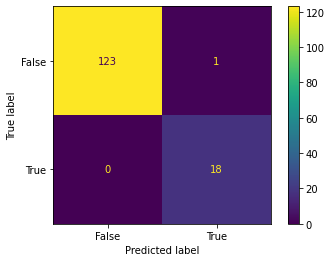

Balanced accuracy:  0.9959677419354839


In [97]:
clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')
cm_test(clf,x,y)

# Recursive feature elimination for selected models

In [98]:
# defining array of number of features to test
N = [1000,500,200,100,50,20,15,10,9,8,7,6,5,4,3,2,1]
N_out = N.copy()
N_out.insert(0,len(x.columns))

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1784 0.681410 (0.147806)
 1:  1000 0.764744 (0.177601)
 2:   500 0.848077 (0.195635)
 3:   200 0.876923 (0.177549)
 4:   100 0.901603 (0.174555)
 5:    50 0.901923 (0.186935)
 6:    20 0.889423 (0.182221)
 7:    15 0.889423 (0.182221)
 8:    10 0.935897 (0.075779)
 9:     9 0.911218 (0.061084)
10:     8 0.915385 (0.062712)
11:     7 0.848718 (0.163793)
12:     6 0.886538 (0.064154)
13:     5 0.882051 (0.066491)
14:     4 0.886538 (0.067189)
15:     3 0.870513 (0.061522)
16:     2 0.883013 (0.083754)
17:     1 0.850000 (0.087996)

 Best number of descriptors =  10


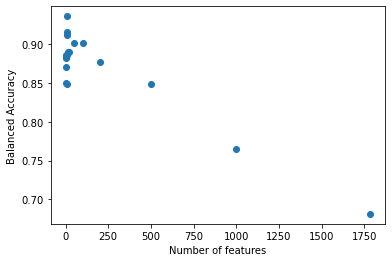

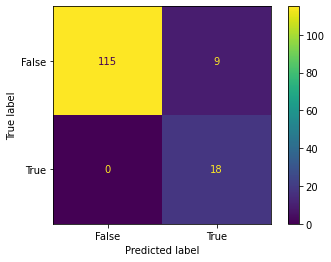

Balanced accuracy:  0.9637096774193548


In [99]:
# Logistic regression
clf = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced', max_iter=1000)

# determine features for each number defined in N
feat_r = multi_feat_red(clf,x,y,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,x,y,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# show confusion matrix for best number of descriptors
cm_test(clf,x[feat_r[N_best]],y)

# output scores to data file
LR_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
LR_scores.to_csv('Data_files/For_plotting/model1_LR_scores.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1784 0.552244 (0.147304)
 1:  1000 0.713462 (0.184946)
 2:   500 0.729808 (0.113618)
 3:   200 0.706410 (0.148886)
 4:   100 0.809295 (0.173919)
 5:    50 0.842308 (0.171100)
 6:    20 0.734295 (0.159282)
 7:    15 0.713141 (0.185750)
 8:    10 0.663141 (0.202032)
 9:     9 0.667308 (0.203347)
10:     8 0.667308 (0.203347)
11:     7 0.667308 (0.203347)
12:     6 0.667308 (0.203347)
13:     5 0.667308 (0.203347)
14:     4 0.567308 (0.120480)
15:     3 0.567308 (0.120480)
16:     2 0.567308 (0.120480)
17:     1 0.567308 (0.120480)

 Best number of descriptors =  50


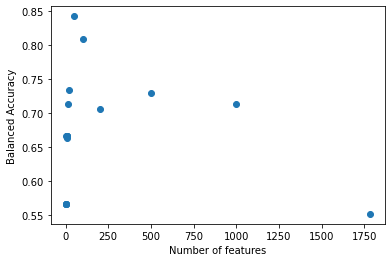

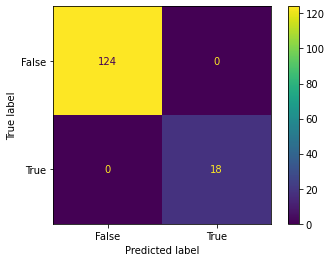

Balanced accuracy:  1.0


In [100]:
# Linear Discriminant Analysis
clf = LinearDiscriminantAnalysis()

# determine features for each number defined in N
feat_r = multi_feat_red(clf,x,y,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,x,y,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# show confusion matrix for best number of descriptors
cm_test(clf,x[feat_r[N_best]],y)

# output scores to data file
LDA_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
LDA_scores.to_csv('Data_files/For_plotting/model1_LDA_scores.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1784 0.614744 (0.224683)
 1:  1000 0.590064 (0.202185)
 2:   500 0.527564 (0.144204)
 3:   200 0.598397 (0.247352)
 4:   100 0.614423 (0.187969)
 5:    50 0.834295 (0.176486)
 6:    20 0.859295 (0.169445)
 7:    15 0.863462 (0.172317)
 8:    10 0.867308 (0.174025)
 9:     9 0.867308 (0.174025)
10:     8 0.867308 (0.174025)
11:     7 0.867308 (0.174025)
12:     6 0.842308 (0.204390)
13:     5 0.838141 (0.201537)
14:     4 0.804487 (0.241820)
15:     3 0.804808 (0.241257)
16:     2 0.718269 (0.216171)
17:     1 0.735256 (0.214107)

 Best number of descriptors =  7


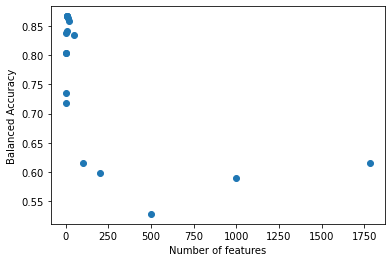

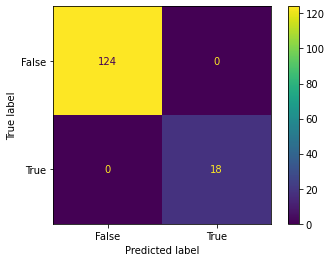

Balanced accuracy:  1.0


In [101]:
# Decision Tree
clf = DecisionTreeClassifier(class_weight='balanced')

# determine features for each number defined in N
feat_r = multi_feat_red(clf,x,y,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,x,y,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# show confusion matrix for best number of descriptors
cm_test(clf,x[feat_r[N_best]],y)

# output scores to data file
DT_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
DT_scores.to_csv('Data_files/For_plotting/model1_DT_scores.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1784 0.643590 (0.204806)
 1:  1000 0.693269 (0.224080)
 2:   500 0.747756 (0.186604)
 3:   200 0.788462 (0.206227)
 4:   100 0.892308 (0.124985)
 5:    50 0.871154 (0.165217)
 6:    20 0.896154 (0.119850)
 7:    15 0.896154 (0.119850)
 8:    10 0.896154 (0.119850)
 9:     9 0.896154 (0.119850)
10:     8 0.892308 (0.124985)
11:     7 0.896154 (0.119850)
12:     6 0.896154 (0.119850)
13:     5 0.896154 (0.119850)
14:     4 0.896154 (0.119850)
15:     3 0.772436 (0.155896)
16:     2 0.747115 (0.172759)
17:     1 0.615705 (0.146116)

 Best number of descriptors =  4


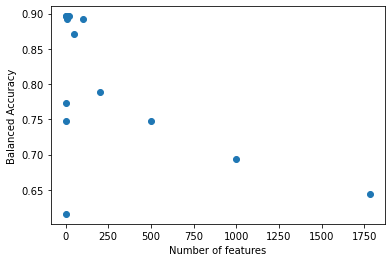

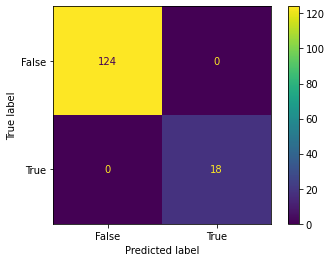

Balanced accuracy:  1.0


In [229]:
# Gradient Boosting
clf = GradientBoostingClassifier()

# determine features for each number defined in N
feat_r = multi_feat_red(clf,x,y,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,x,y,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# show confusion matrix for best number of descriptors
cm_test(clf,x[feat_r[N_best]],y)

# output scores to data file
GB_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
GB_scores.to_csv('Data_files/For_plotting/model1_GB_scores.csv')

           Balanced accuracy
 i     N    Mean      (SD)
 0:  1784 0.545833 (0.102825)
 1:  1000 0.546154 (0.102556)
 2:   500 0.546154 (0.102556)
 3:   200 0.567308 (0.120480)
 4:   100 0.538462 (0.108445)
 5:    50 0.667308 (0.192893)
 6:    20 0.633974 (0.213404)
 7:    15 0.687821 (0.230360)
 8:    10 0.634295 (0.239963)
 9:     9 0.659295 (0.209744)
10:     8 0.647115 (0.211414)
11:     7 0.546795 (0.175618)
12:     6 0.596795 (0.172951)
13:     5 0.625962 (0.183461)
14:     4 0.604808 (0.179281)
15:     3 0.604808 (0.173374)
16:     2 0.647436 (0.191917)
17:     1 0.739423 (0.213948)

 Best number of descriptors =  1


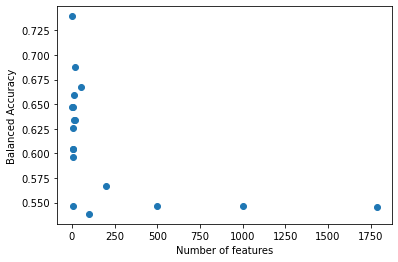

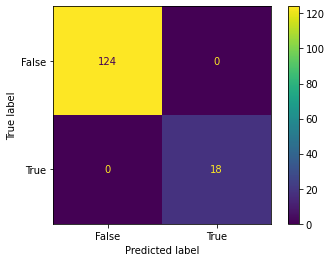

Balanced accuracy:  1.0


In [230]:
# Random Forest
clf = RandomForestClassifier(class_weight='balanced')

# determine features for each number defined in N
feat_r = multi_feat_red(clf,x,y,N,'RFE')

# determine scores for each set of features
N_best,scores,stdevs = feat_comp(clf,feat_r,x,y,len(x.columns))

print('\n Best number of descriptors = ',N[N_best])

# show confusion matrix for best number of descriptors
cm_test(clf,x[feat_r[N_best]],y)

# output scores to data file
RF_scores = pd.DataFrame({'N':N_out,'Scores':scores,'SD':stdevs})
RF_scores.to_csv('Data_files/For_plotting/model1_RF_scores.csv')

# Evaluating best model obtained through RFE with test compounds

In [231]:
# Logistic regression
clf = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced', max_iter=1000)

# determine features for each number defined in N
feat_r = multi_feat_red(clf,x,y,N,'RFE')

# using best N from above
N_best = 8

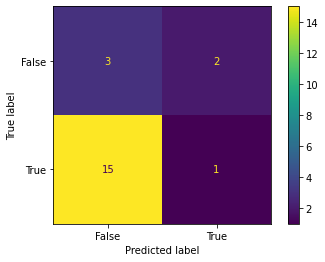

Balanced accuracy: 0.33125


In [232]:
clf = LogisticRegression(solver='liblinear', multi_class='ovr', class_weight='balanced', max_iter=1000)
clf.fit(x[feat_r[N_best]],y)

test_molecules = pd.read_csv('Data_files/descriptors_test_compounds.csv')

X_test = test_molecules

X_test[X.columns] = scaler.transform(X_test[X.columns])
Y_test = test_molecules['siRNA complexing']

Y_pred = clf.predict(X_test[feat_r[N_best]])

cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()
print('Balanced accuracy:', balanced_accuracy_score(Y_test,Y_pred))

# Alternative descriptor selection method

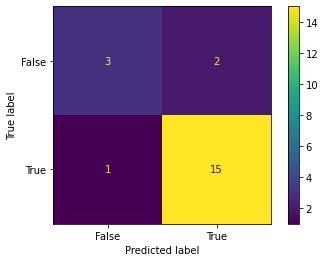

0.76875


In [233]:
desc_sel = best5
clf.fit(x[desc_sel],y)
Y_pred = clf.predict(X_test[desc_sel])
cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()
print(balanced_accuracy_score(Y_test,Y_pred))


In [236]:
# try splitting into a bunch of random balanced fits and see which features show up frequently (can use LOO)

feat_r = []
for i in range(100):
    indices = y[y==False].sample(n=18).index
    X2 = pd.concat([x[y==True],x.loc[indices]])
    Y2 = pd.concat([y[y==True],y[indices]])
    clf.fit(X2,Y2)
    feat_r.append(feat_red(clf.X2,Y2,10,'RFE',0,0))
    clf.fit(X2[feat_r[i]],Y2)
    cm_test(clf,X2[feat_r[i]],Y2)
    print(i,feat_r[i])

ValueError: Expected 2D array, got 1D array instead:
array=[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
 False False False False False False False False False False False False].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

<AxesSubplot:>

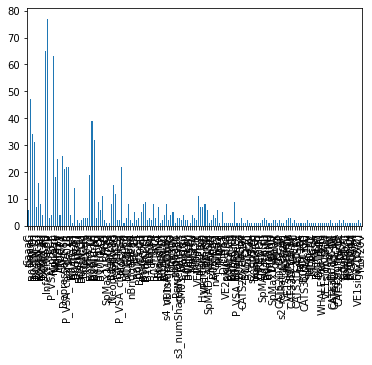

In [185]:
counts = pd.Series(np.stack(feat_r).flatten()).value_counts(sort=False)
counts.plot(kind='bar')

In [183]:
#counts.to_csv('descriptor_ranking.csv')
#counts = pd.read_csv('descriptor_ranking.csv')
#df = pd.read_csv('descriptor_ranking.csv', index_col=False, header=0);
#counts = df.set_index('Unnamed: 0')
#counts = counts.transpose()

0    1
Name: Mor21m, dtype: int64

In [178]:
desc_rank = counts.index

In [77]:
counts = pd.read_csv('descriptor_ranking.csv')


In [81]:
sum(counts['0']>9)

27

In [179]:
np.argmax(counts)

9

In [181]:
#counts['Mor32m']

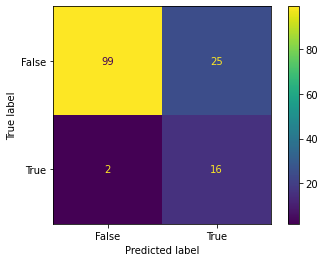

0.8436379928315412


In [25]:
descs=['Mor32m']

X_train2 = x[descs]

clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')

#clf = DecisionTreeClassifier(class_weight='balanced',max_depth=2,min_samples_leaf=2)
clf.fit(X_train2,y)

predictions = clf.predict(X_train2)

cm = confusion_matrix(y, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()

print(balanced_accuracy_score(y,clf.predict(X_train2)))

In [62]:
desc_best = []
for _ in range(10):
    scores_train = []
    scores_test = []
    descs = []
    for desc in desc_rank:
        #print(desc)
        descs = desc_best.copy()
        descs.append(desc)
   
        X_train2 = x[descs]

        clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')

        clf.fit(X_train2,y)

        predictions = clf.predict(X_train2)
        predictions_test = clf.predict(test_molecules_2[descs])

        scores_train.append(balanced_accuracy_score(y,clf.predict(X_train2)))
        scores_test.append(balanced_accuracy_score(test_molecules_2['Experimental'],clf.predict(test_molecules_2[descs])))

        #print(balanced_accuracy_score(y,clf.predict(X_train2)))
    desc_best.append(desc_rank[np.argmax(scores_train)])
    print(desc_best,max(scores_train),scores_test[np.argmax(scores_train)])

['Mor32m'] 0.8436379928315412 0.425
['Mor32m', 'nR06'] 0.907258064516129 0.51875
['Mor32m', 'nR06', 'VE1sign_B(s)'] 0.9233870967741935 0.6125
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6'] 0.9314516129032258 0.575
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s'] 0.939516129032258 0.575
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH'] 0.9435483870967742 0.575
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH', 'B09[N-F]'] 0.9435483870967742 0.5125
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH', 'B09[N-F]', 'B09[N-F]'] 0.9435483870967742 0.5125
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH', 'B09[N-F]', 'B09[N-F]', 'B09[N-F]'] 0.9435483870967742 0.5125
['Mor32m', 'nR06', 'VE1sign_B(s)', 'P_VSA_LogP_6', 'HATS6s', 'minaaNH', 'B09[N-F]', 'B09[N-F]', 'B09[N-F]', 'B09[N-F]'] 0.9435483870967742 0.5125


In [ ]:
['Mor32m'] 0.8436379928315412
['Mor32m', 'Mor25m'] 0.8794802867383513
['Mor32m', 'Mor25m', 'ALOGP2'] 0.9274193548387097
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG'] 0.9314516129032258
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m'] 0.9435483870967742
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP'] 0.9475806451612903
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP', 'B10[N-N]'] 0.9475806451612903
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP', 'B10[N-N]', 'nArCONR2'] 0.9516129032258065
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP', 'B10[N-N]', 'nArCONR2', 'SpMAD_EA(ri)'] 0.9556451612903225
['Mor32m', 'Mor25m', 'ALOGP2', 'VE1sign_RG', 'RDF040m', 'CATS3D_04_AP', 'B10[N-N]', 'nArCONR2', 'SpMAD_EA(ri)', 'EE_G'] 0.9596774193548387

In [62]:
desc_best

['Mor32m', 'Mor25m']

In [48]:
desc_best = []
desc_best.append(desc_rank[np.argmax(scores)])

In [49]:
desc_best

['Mor32m']

In [35]:
desc_best.append(desc_rank[np.argmax(scores)])

AttributeError: 'str' object has no attribute 'append'

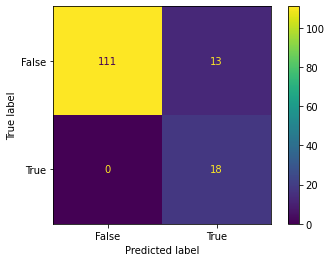

0.9475806451612903
0.8846153846153846


,Name,SMILES,experimental,prediction
0,Amiodarone,CCCCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)I)O...,True,True
1,Apilimod,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,True,False
2,Chlorpromazine,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl,True,True
3,Emetine,CCC1CN2CCC3=CC(=C(C=C3C2CC1CC4C5=CC(=C(C=C5CCN...,False,False
4,Emetine analog,CC[C@@H]1[C@@H](C[C@H](C2=C3)N(CCCCCCCC/C=C\CC...,True,True
5,Levofloxacin,CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(...,False,False
6,MC3,CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OC(...,True,True
7,Netarsudil,CC1=CC(=C(C=C1)C(=O)OCC2=CC=C(C=C2)C(CN)C(=O)N...,True,False
8,Siramesine,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...,True,True
9,Sorafenib,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,False,False


In [11]:
descs=['Mor32m']
descs = best5
X_train2 = X_reduced[descs]

clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')

clf.fit(X_train2,Y)

predictions = clf.predict(X_train2)

cm = confusion_matrix(Y, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()

print(balanced_accuracy_score(Y,clf.predict(X_train2)))

test_predict = clf.predict(test_molecules[X[descs].columns])
molecules['prediction'] = test_predict
molecules

print(sum(molecules['prediction']==molecules['experimental'])/len(molecules['prediction']))
molecules

In [101]:
desc_rank_10 = desc_rank[counts>9]
n = len(desc_rank_10)
scores = np.zeros((n,n))
i=0
j=0
for desc1 in desc_rank_10:
    j=0
    for desc2 in desc_rank_10:
        descs = [desc1,desc2]
   
        X_train2 = x[descs]

        clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')
        clf.fit(X_train2,y)

        predictions = clf.predict(X_train2)
        scores[i,j] = balanced_accuracy_score(y,clf.predict(X_train2))
        j=j+1
    i=i+1

ind_best = np.asarray(np.unravel_index(scores.argmax(),scores.shape))
print('Maximum score of:',scores[ind_best[0],ind_best[1]],' for ',
      desc_rank_10[ind_best[0]],'&',
      desc_rank_10[ind_best[1]])

Maximum score of: 0.8794802867383513  for  Mor25m & Mor32m


In [82]:
freq_thresh = 9
max_desc = 5

best_scores = []
best_combs = []

for i in range(max_desc):
    print (i)
    [best_comb, best_score,best_test_score,_,_] = best_desc_comb(desc_rank,freq_thresh,i+1,x,y,test_molecules_2,test_molecules_2['Experimental'])
    best_combs.append(best_comb)
    best_scores.append(best_score)

'1294/17550'

KeyboardInterrupt: 

In [226]:
freq_thresh = 9
max_desc = 7

best_scores = []
best_combs = []

for i in range(max_desc):
    print (i)
    [best_comb, best_score,_,_] = best_desc_comb(desc_rank,freq_thresh,i+1)
    best_combs.append(best_comb)
    best_scores.append(best_score)

'657800/657800'

Maximum score of: 0.9556451612903225  for  ('B03[N-O]', 'B09[N-O]', 'Infective-80', 'Mor32m', 'B05[N-F]', 's4_numAroBonds', 'B08[O-O]')


In [97]:
best_comb_scores = pd.DataFrame()
best_comb_scores['Descriptors'] = best_combs
best_comb_scores['Scores'] = best_scores
best_comb_scores

,Descriptors,Scores
0,[Mor32m],0.843638
1,"[Mor32m, Mor25m]",0.879480
2,"[Mor32m, ALOGP2, VE1sign_RG]",0.939516


In [122]:
best1 = ['Mor32m']
best2 = ['Mor32m', 'Mor25m']
best3 = ['Mor32m', 'ALOGP2', 'VE1sign_RG']
best4 = ['Mor32m', 'ALOGP2', 'B05[N-F]', 'VE1sign_RG']
best5 = ['Mor32m', 'NaaaC', 'ALOGP2', 'VE1sign_RG', 'B04[N-O]']
best6 = ['B03[N-O]', 'Infective-80', 'Mor32m', 'B05[N-F]', 's4_numAroBonds', 'B08[O-O]']
best7 = ['B03[N-O]', 'B09[N-O]', 'Infective-80', 'Mor32m', 'B05[N-F]', 's4_numAroBonds', 'B08[O-O]']

In [131]:
desc_sel = best4
clf.fit(x[desc_sel],y)
print(balanced_accuracy_score(test_molecules_2['Experimental'],clf.predict(test_molecules_2[desc_sel])))

0.86875


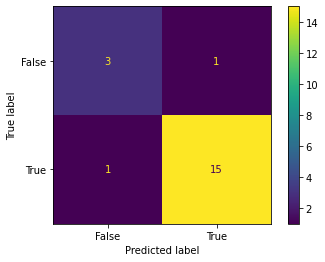

0.84375


In [76]:
desc_sel = best5
clf.fit(x[desc_sel],y)
predictions = clf.predict(test_molecules_3[desc_sel])
cm = confusion_matrix(test_molecules_3['Experimental'], predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()
#print(balanced_accuracy_score(test_molecules_3['Experimental'],clf.predict(test_molecules_3[feat_r[N_best]])))
print(balanced_accuracy_score(test_molecules_3['Experimental'],clf.predict(test_molecules_3[desc_sel])))


In [11]:
balanced_accuracy_score


<function sklearn.metrics._classification.balanced_accuracy_score(y_true, y_pred, *, sample_weight=None, adjusted=False)>

In [13]:
molecules


,Name,SMILES,prediction
0,Amiodarone,CCCCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)I)O...,True
1,Apilimod,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...,False
2,Chlorpromazine,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl,False
3,Emetine,CCC1CN2CCC3=CC(=C(C=C3C2CC1CC4C5=CC(=C(C=C5CCN...,True
4,Emetine analog,CC[C@@H]1[C@@H](C[C@H](C2=C3)N(CCCCCCCC/C=C\CC...,False
5,Levofloxacin,CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(...,False
6,MC3,CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OC(...,False
7,Netarsudil,CC1=CC(=C(C=C1)C(=O)OCC2=CC=C(C=C2)C(CN)C(=O)N...,True
8,Siramesine,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...,True
9,Sorafenib,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,True


In [14]:
molecules['experimental'] = [True,True,True,False,True,False,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True]

In [28]:
sum(molecules['prediction']==molecules['experimental'])/len(molecules['prediction'])


0.34615384615384615

In [19]:
molecules

,Name,SMILES
0,Amiodarone,CCCCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)I)O...
1,Apilimod,CC1=CC(=CC=C1)C=NNC2=CC(=NC(=N2)OCCC3=CC=CC=N3...
2,Chlorpromazine,CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl
3,Emetine,CCC1CN2CCC3=CC(=C(C=C3C2CC1CC4C5=CC(=C(C=C5CCN...
4,Emetine analog,CC[C@@H]1[C@@H](C[C@H](C2=C3)N(CCCCCCCC/C=C\CC...
5,Levofloxacin,CC1COC2=C3N1C=C(C(=O)C3=CC(=C2N4CCN(CC4)C)F)C(...
6,MC3,CCCCCC=CCC=CCCCCCCCCC(CCCCCCCCC=CCC=CCCCCC)OC(...
7,Netarsudil,CC1=CC(=C(C=C1)C(=O)OCC2=CC=C(C=C2)C(CN)C(=O)N...
8,Siramesine,C1CN(CCC12C3=CC=CC=C3CO2)CCCCC4=CN(C5=CC=CC=C5...
9,Sorafenib,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...


In [13]:
descs=best5

X_train2 = X_reduced[descs]

clf = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight='balanced')

clf.fit(X_train2,Y)

pickle.dump(clf, open("best_model.p", "wb"))
pickle.dump(descs, open("best_features.p","wb"))
pickle.dump(scaler, open("scaler.p","wb"))
pickle.dump(X, open("X.p","wb"))
pickle.dump(data,open("data.p","wb"))


In [10]:
data

,SMILES,CASRN,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment,RG,Group,RG_binary
0,[H][C@]12C[C@@H](OC(=O)C3=CC(OC)=C(OC)C(OC)=C3...,50-55-5,Reserpine,608.8,7.247,51.49,84.94,53.57,94.77,0.6129,...,6.667,34.17,0.7765,9.000,0.20450,30.00,8.249,0.707069,1,False
1,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,83905-01-5,Azithromycin,749.1,6.041,67.06,124.10,72.11,142.00,0.5408,...,0.000,48.08,0.9247,13.030,0.25050,58.19,15.960,1.054428,1,False
2,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,55142-85-3,Ticlopidine,263.8,8.510,20.72,30.69,22.84,34.27,0.6685,...,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,1.057829,1,False
3,CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1,59729-33-8,Citalopram,324.4,7.210,28.41,44.88,30.02,50.70,0.6313,...,6.000,15.00,0.6250,1.000,0.04167,9.11,1.732,1.015802,1,False
4,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,159989-64-7,Nelfinavir,567.9,6.681,50.17,84.25,54.47,95.97,0.5903,...,9.600,35.10,0.8775,6.800,0.17000,37.32,7.605,1.156914,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,CC1=CC(C)=C(Br)C(C)=C1NC(=O)CN(CC(O)=O)CC(O)=O,78266-06-5,Mebrofenin,387.3,9.220,26.38,43.02,27.49,47.62,0.6282,...,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,1.127932,6,False
138,[H][C@]12CCC[C@H](N1C(=O)[C@H](CCS2)NC(=O)[C@@...,167305-00-2,Omapatrilat,408.6,8.012,32.07,51.39,34.50,57.24,0.6288,...,4.500,23.75,0.8796,6.000,0.22220,28.61,8.513,1.091463,6,False
139,[H][C@@]12CC3=C(C(O)=CC=C3)C(=O)C1=C(O)[C@]1(O...,15866-90-7,Incyclinide,371.4,8.440,29.24,45.46,29.28,49.29,0.6645,...,3.333,19.83,0.7346,6.667,0.24690,16.41,6.644,0.890418,6,False
140,NC1=CC=C(C=C1)S(=O)(=O)NC(=O)C1=CC=CC=C1,127-71-9,Sulfabenzamide,276.3,8.914,21.01,31.68,21.83,34.62,0.6777,...,0.000,0.00,0.0000,0.000,0.00000,0.00,0.000,1.012424,6,False


In [ ]:
# save features from best model
# best5 = ['Mor32m', 'NaaaC', 'ALOGP2', 'VE1sign_RG', 'B04[N-O]']
